In [1]:
# Let's load our libraries - add others you might want here

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import joblib

In [2]:
# Load in the training data - your test data has no labels
data = pd.read_csv('./data/ADT_training.csv')

def add_features(data):
    """function to add some time series related features"""
    # create squared data
    data['data_squared'] = data['data'] ** 2
    data['data_tripled'] = data['data'] ** 3
    # create lag
    for i in range(100):
        data[f'data_lag_{i + 1}'] = data['data'].shift(i + 1)
    return data

data = add_features(data)

# Let's get a training and validation set for our data
train_X = data.drop("anomaly", axis=1).iloc[:7000, :].values
train_y = data.iloc[:7000, 1].values

val_X = data.drop("anomaly", axis=1).iloc[7000:, :].values
val_y = data.iloc[7000:, 1].values

# Load the test data 
test_data = pd.read_csv('./data/ADT_test.csv')
test_data = add_features(test_data)

test_X = test_data.drop("anomaly", axis=1).values

/var/folders/3h/4jmysmpn7898c3h13h3lwnthf0k6lv/T/ipykernel_56096/623559784.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'data_lag_{i + 1}'] = data['data'].shift(i + 1)


In [82]:
def remove_outliers(train_X):
    train_x = train_X
    upper_limit = train_x.mean() + 3*train_x.std()
    lower_limit = train_x.mean() - 3*train_x.std()
    # taking out the outliers
    new_train_x = np.where(
        train_x>upper_limit,
        upper_limit,
        np.where(
            train_x<lower_limit,
            lower_limit,
            train_x
        )
    )
    
    return new_train_x

new_train_x = remove_outliers(train_X)
print(train_X.shape, new_train_x.shape)

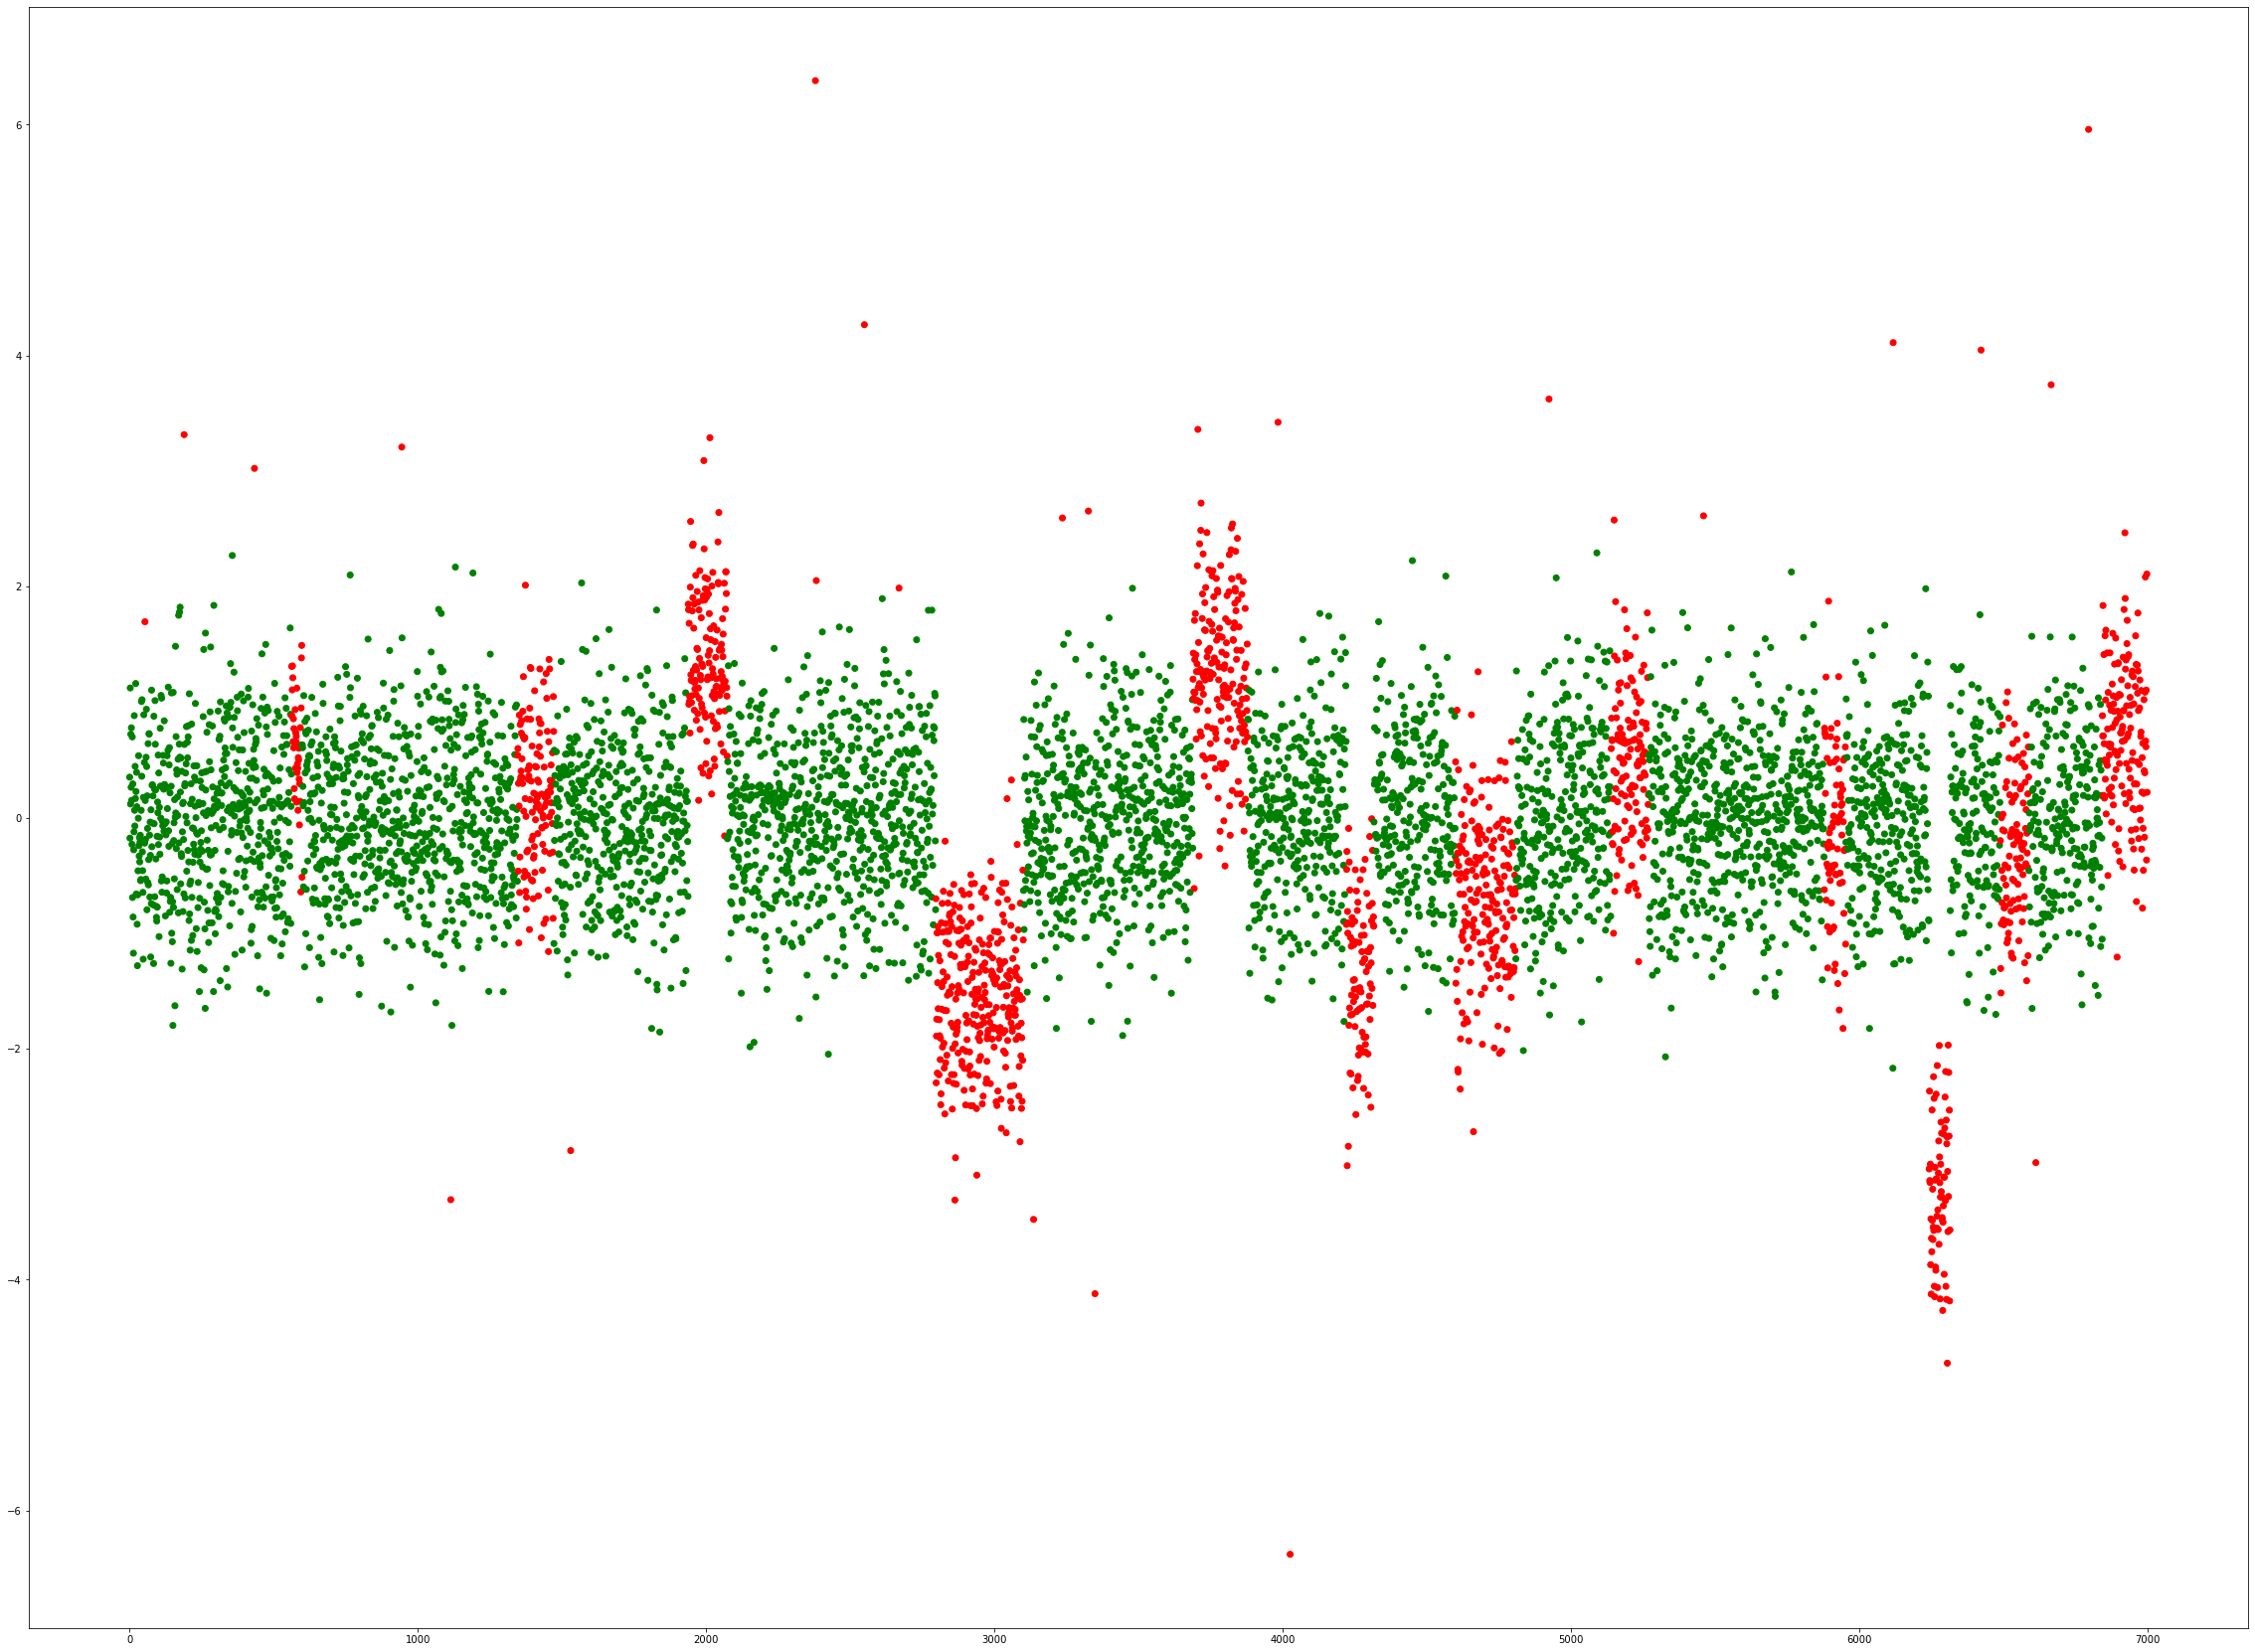

In [138]:
# Look at complete training data and where anomalies lie

plt.figure(figsize=(40, 30))

color = np.where(train_y==1,'r','g')

plt.scatter(np.arange(len(train_X)), data.iloc[:7000, 0].values, c=color)


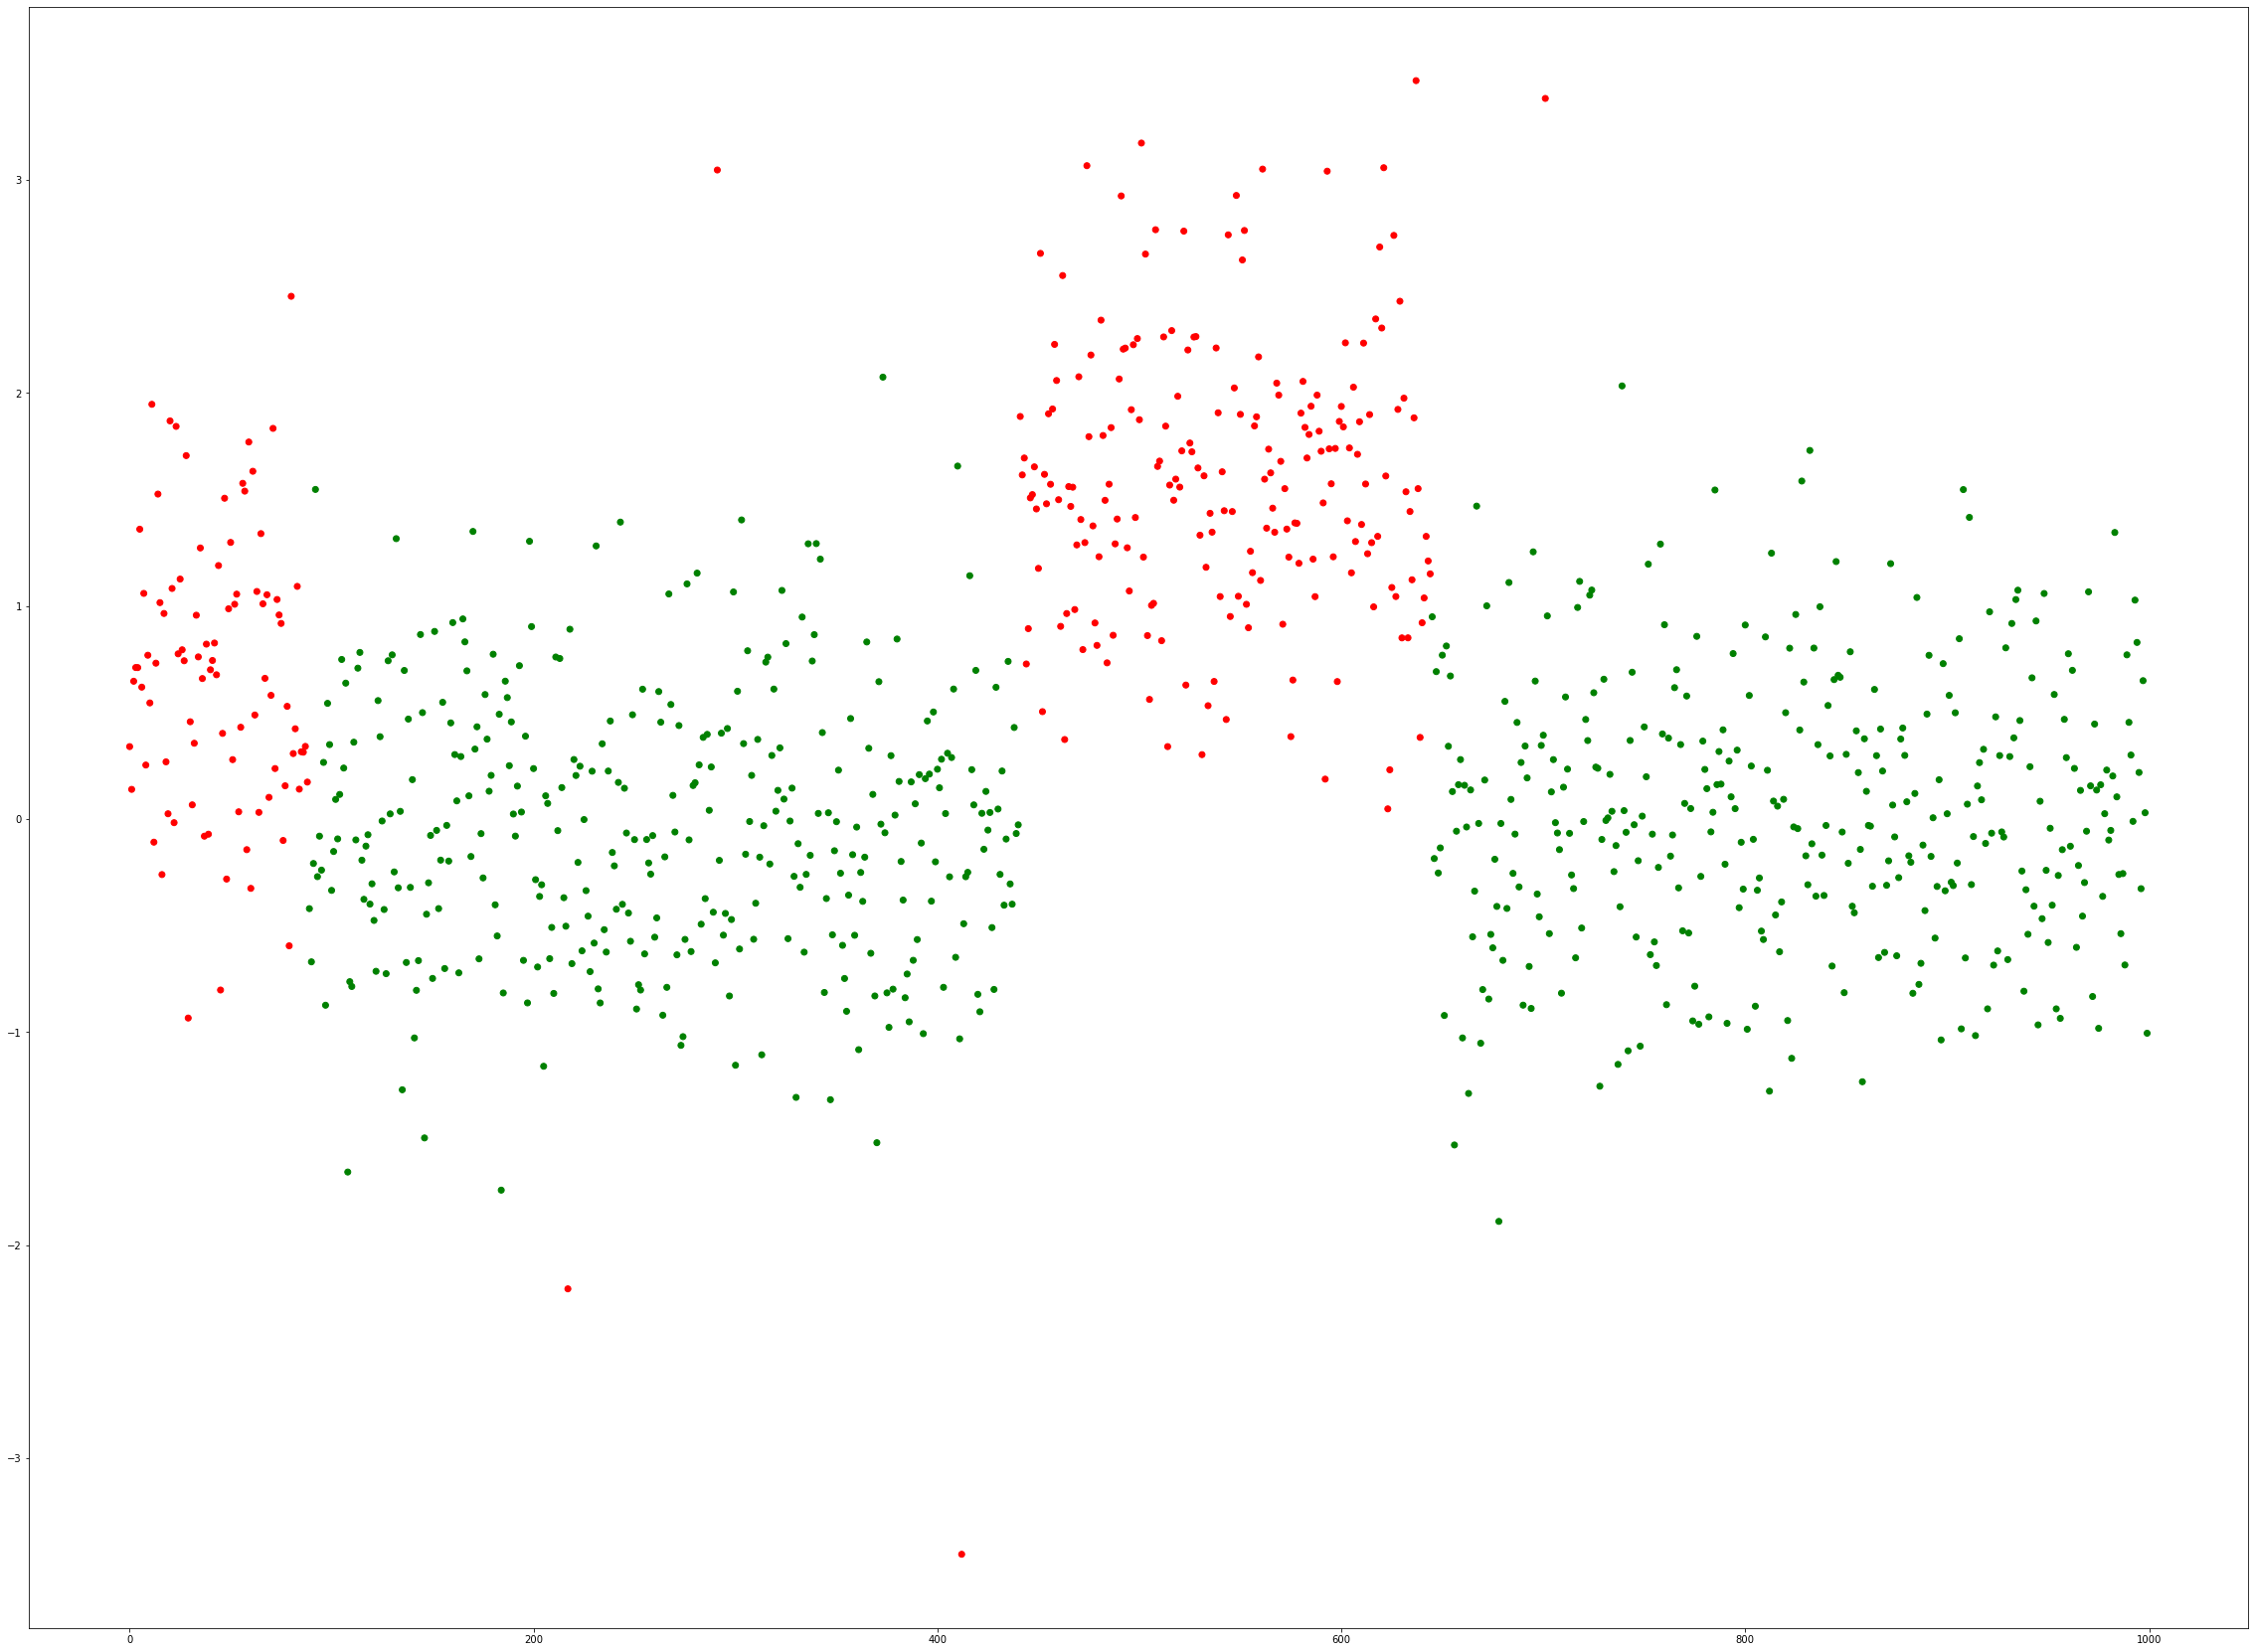

In [139]:
# Look at complete validation data and where anomalies lie

plt.figure(figsize=(40, 30))

color = np.where(val_y==1,'r','g')

plt.scatter(np.arange(len(val_X)), data.iloc[7000:, 0].values, c=color)


In [16]:
# Training an XGBClassifier model
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def evaluate_model(X_train, X_test, y_train, model_name, y_test=None):
    # split data into train and test sets
    seed = 7
    # fit model no training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # dumping model as a pickle file
    with open(model_name, 'wb') as pickle_file:
        joblib.dump(model, pickle_file)
    
    if y_test is not None:
        f1_score_result = f1_score(y_test, y_pred)
    else: 
        f1_score_result = 0

    return y_pred, f1_score_result

In [55]:
# Train on training dataset and evaluate on validation dataset
y_pred_train, f1_score_train = evaluate_model(train_X, 
                              val_X, 
                              train_y, 
                              "xgboost.pkl",
                              val_y)


# Train on every datapoint, including the validation test set
y_pred_all, f1_score_all = evaluate_model(data.drop("anomaly", axis=1).values, 
                            test_X, 
                            data["anomaly"].values, 
                            "xgboost_all_data.pkl")


print(f"F1-Score train-val: {f1_score_train}")

/Users/nguyehoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nguyehoa/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:03:28] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-Score train-val: 0.9707401032702236, F1-Score all: 0


In [39]:
import time

def generate_data_to_return(model_name, file_name, test_X):
    """generates CSV file to hand in as a solution"""
    # load model
    model = joblib.load(model_name)
    # Make predictions with your model, one line at a time. This allows testing for the
    # Average Detection Delay
    y_preds = []
    detection_delay = []
    for i in range(len(test_X)):
        ts = time.time()
        y_pred = model.predict(test_X[[i]])
        te = time.time()
        detection_delay.append(ts-te)
        y_preds.append(y_pred[0])
    def average(lst):
        return sum(lst) / len(lst)
    # Here is how you would write out the data to allow us to compare your results
    test_results = pd.DataFrame(data={'results': y_preds})
    # write them out to this file which you'll submit to us
    test_results.to_csv(file_name)
    return average(detection_delay)

In [40]:
average_stuff = generate_data_to_return("xgboost.pkl", "results_data_evaluation_group_neukoelln.csv", test_X)
average_stuff

-0.0015040348768234253

In [41]:
average_stuff_all_data = generate_data_to_return("xgboost_all_data.pkl", "results_all_data_data_evaluation_group_neukoelln.csv",test_X)
average_stuff_all_data

-0.001445574402809143

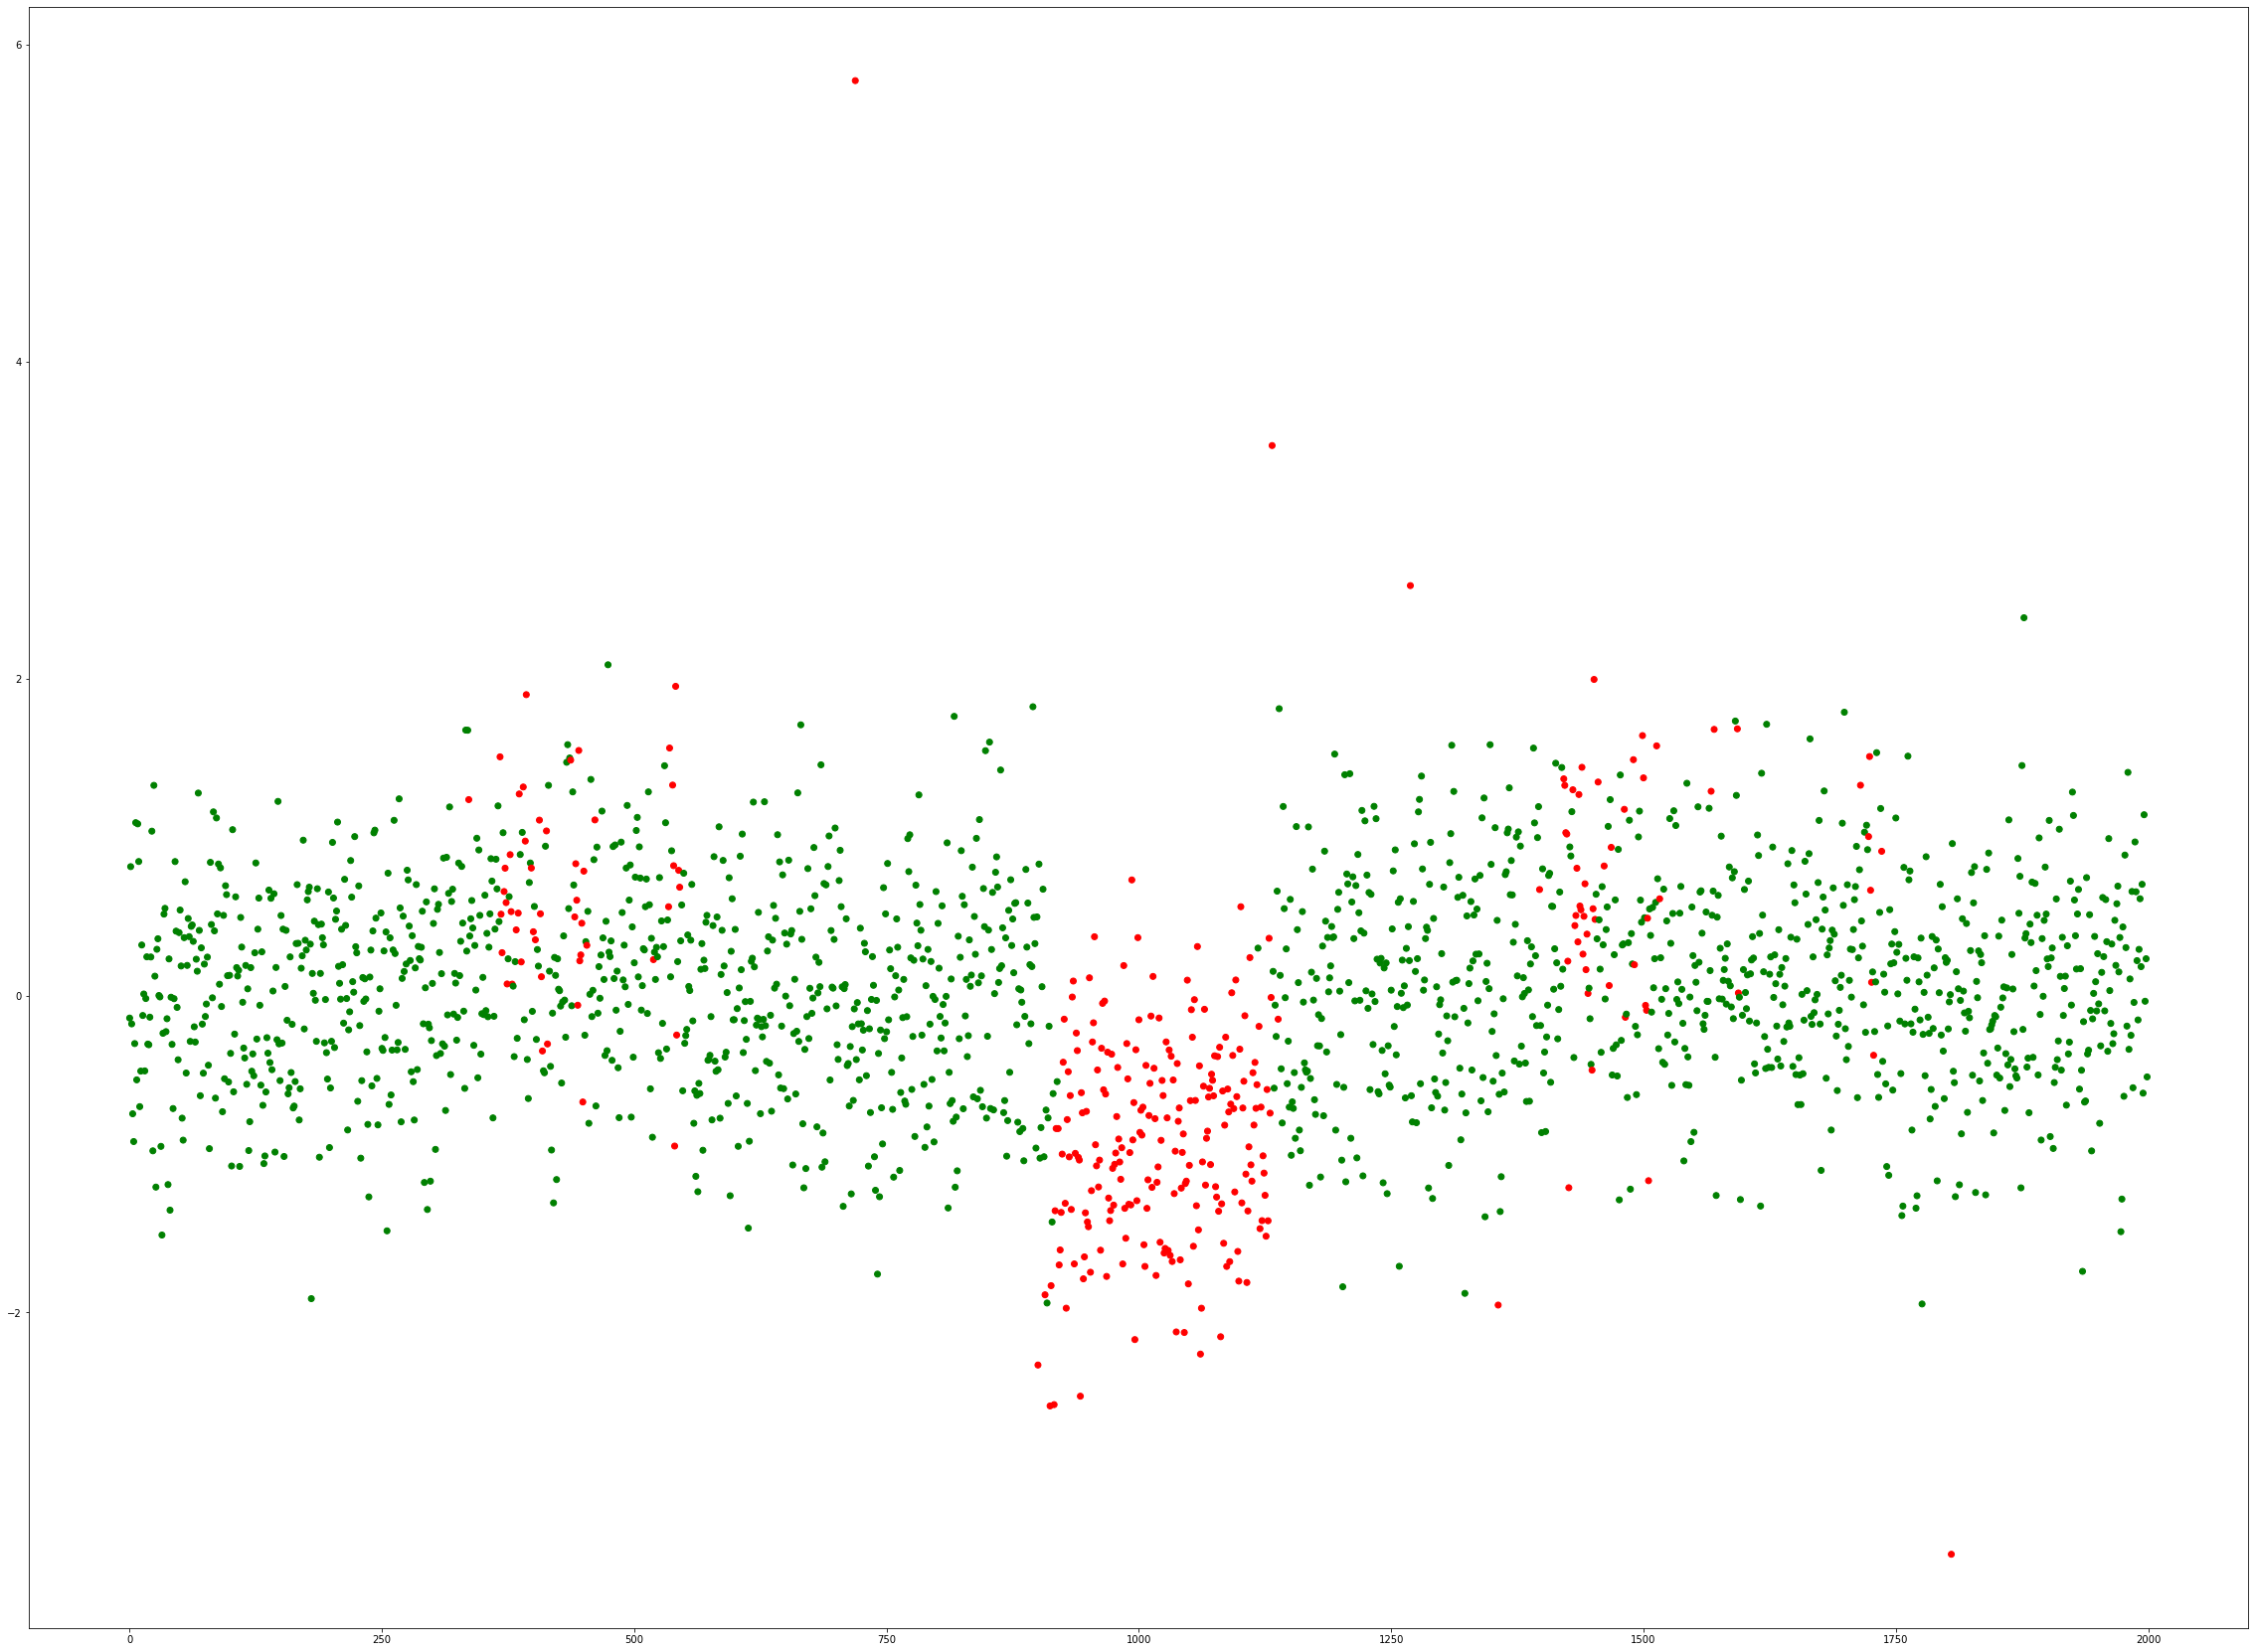

In [125]:
# Visualize test data with xgboost.pkl model
plt.figure(figsize=(40, 30))

color = np.where(y_pred_train==1,'r','g')
color = np.where(val_y==1,'r','g')

plt.scatter(np.arange(len(test_X)), test_data.iloc[:, 0].values, c=color)


In [47]:
test_data.iloc[:, 0].values

array([-0.14160282,  0.81403287, -0.17837703, ..., -0.03541848,
        0.23282743, -0.51300832])

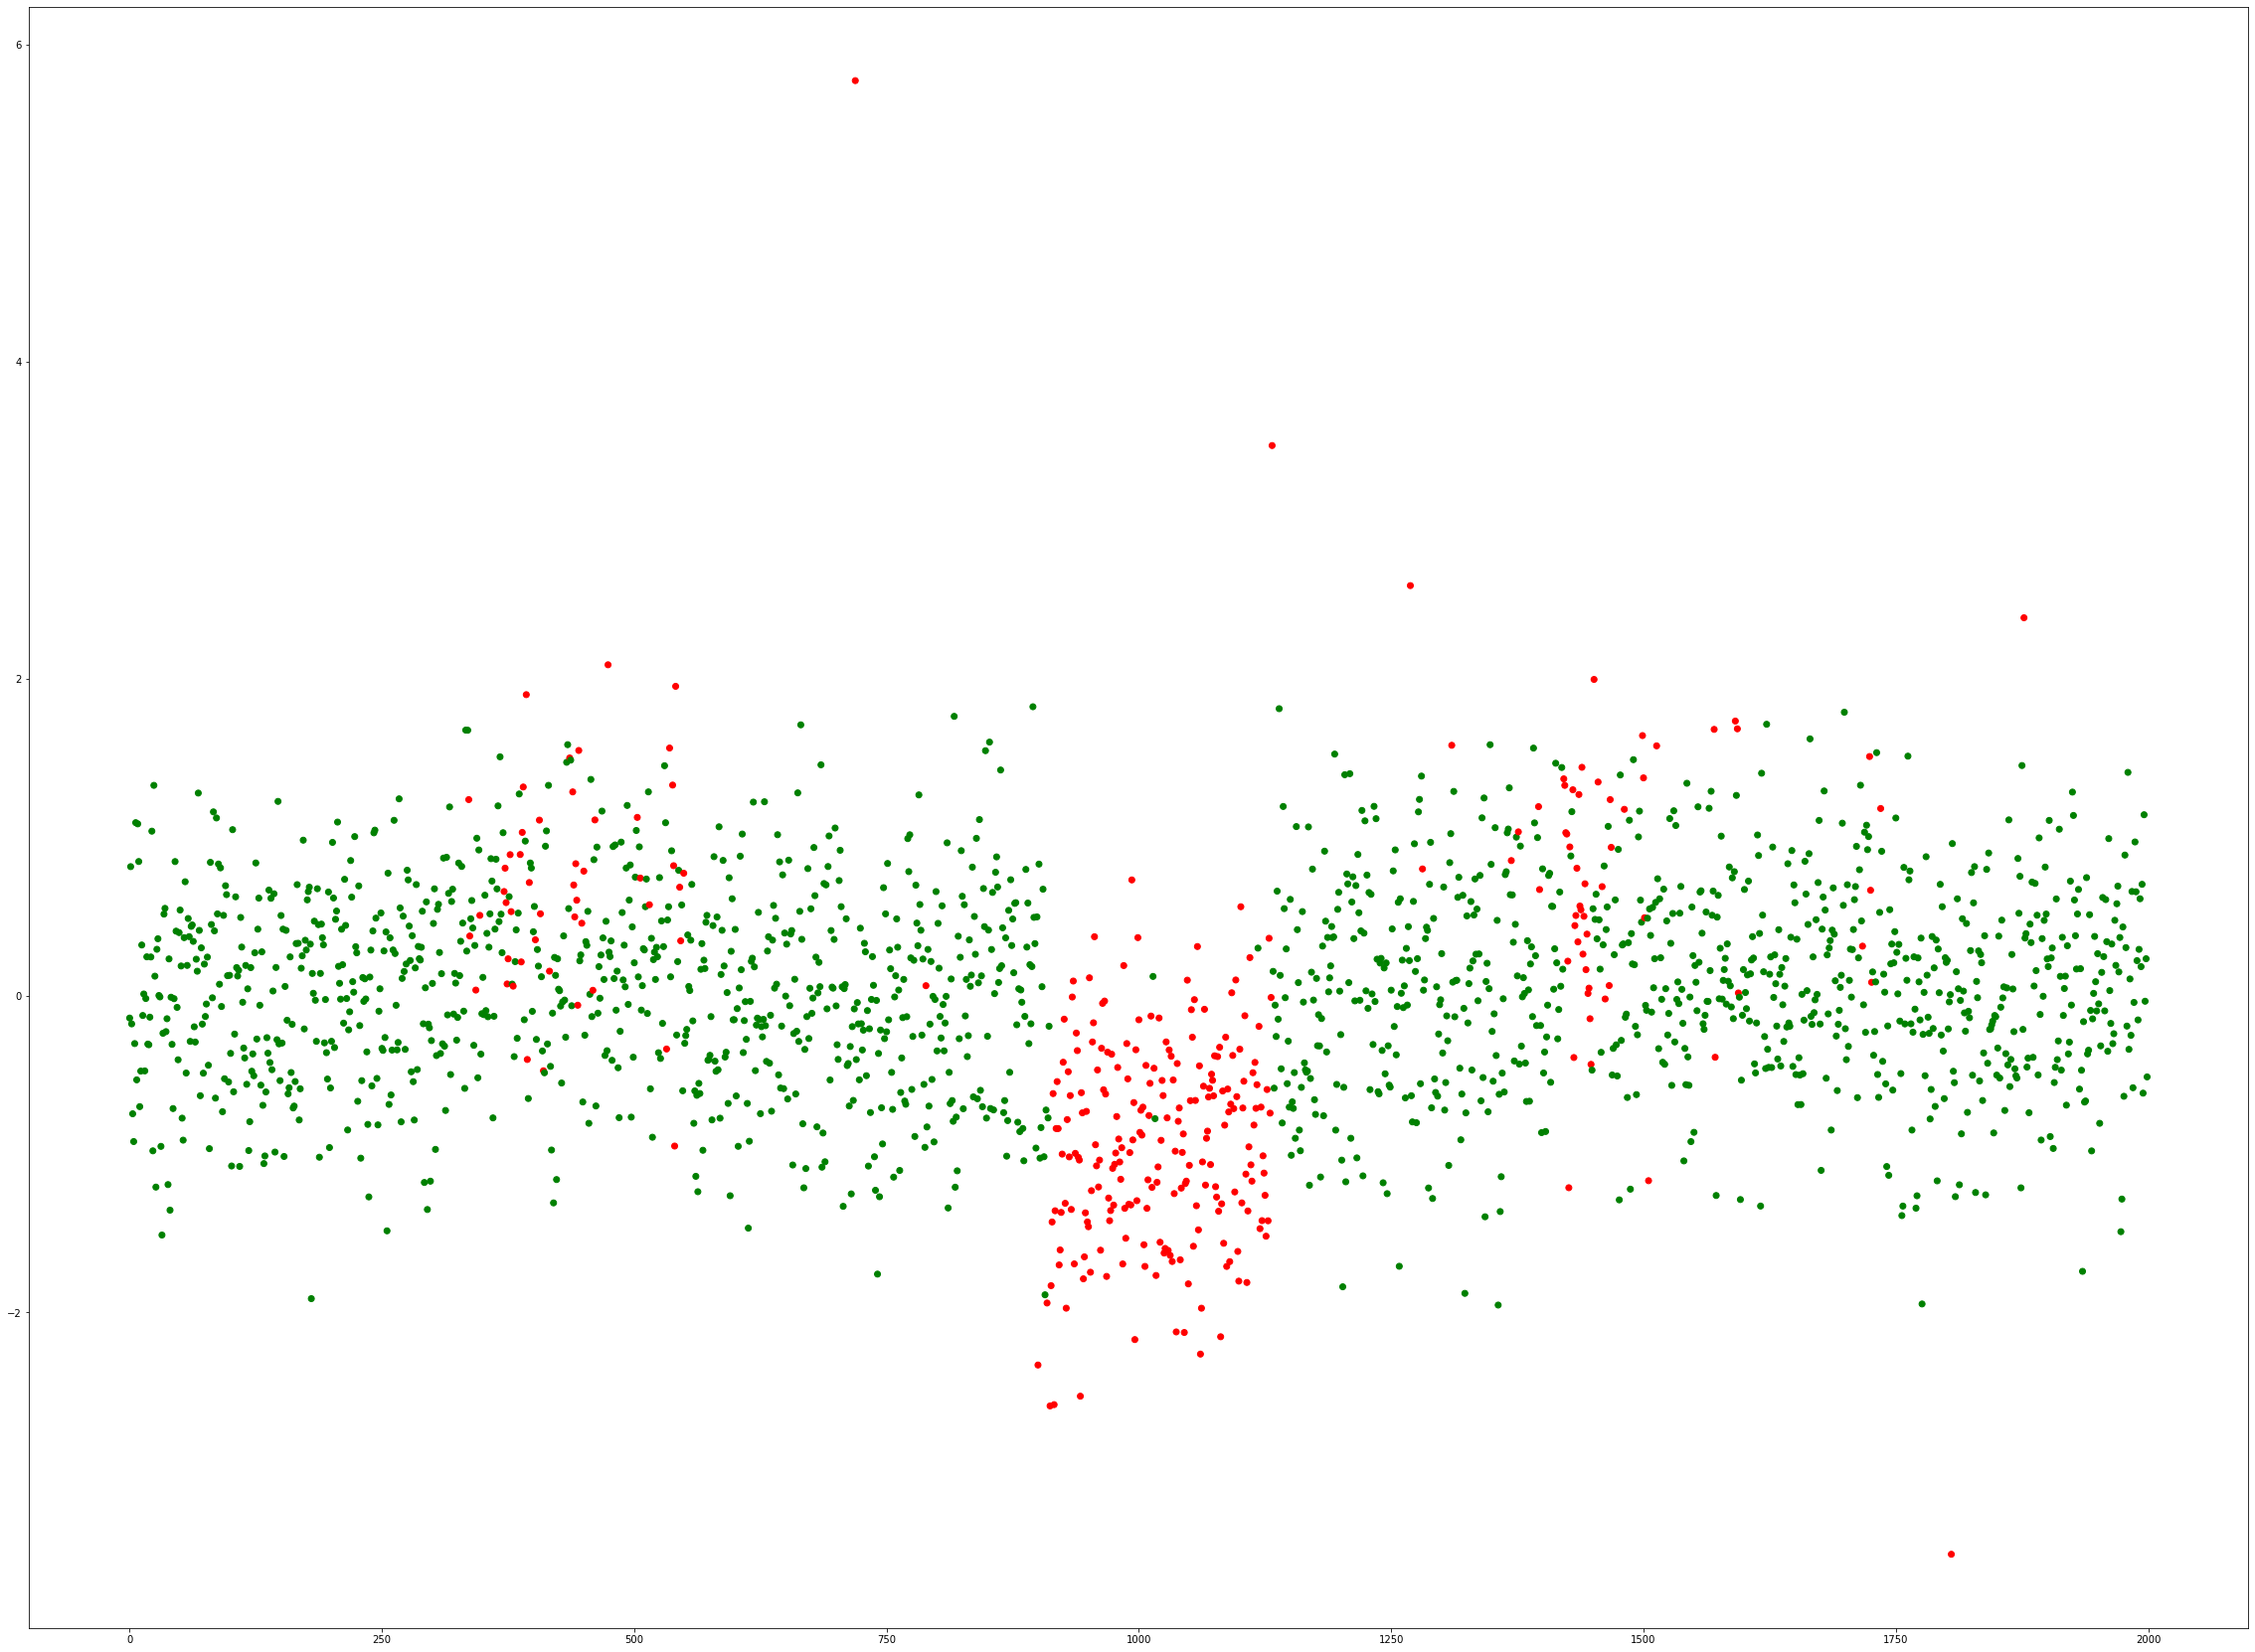

In [54]:
# Visualize test data with xgboost_all_data.pkl model
plt.figure(figsize=(40, 30))

color = np.where(y_pred_all==1,'r','g')

plt.scatter(np.arange(len(test_X)), test_data.iloc[:, 0].values, c=color)


In [126]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import f1_score

f1_score_result = f1_score(y_test, y_pred)
print(f"F1-Score: {f1_score_result}")

Accuracy: 98.30%
F1-Score: 0.9707401032702236
